Next steps:
- Follow [supervised learning](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)
- Follow [unsupervised learning](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import pandas as pd

In [2]:
# Load data

from seattlecycling.data import get_fremont_data
data = get_fremont_data()
data = data.loc['1 Oct 2012':'14 May 2014']
data.head()

,total,west,east
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [3]:
# Resample data into daily and weekly totals

daily = data.resample('d').sum()
weekly = data.resample('w').sum()

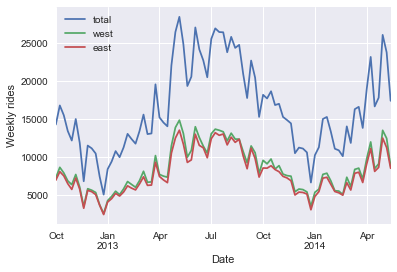

In [4]:
# A first look at the data

weekly.plot();
plt.ylabel('Weekly rides');

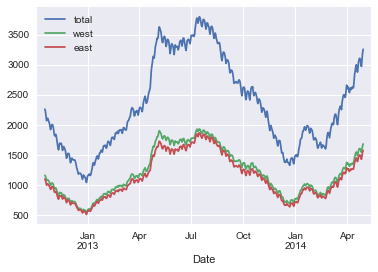

In [5]:
# Look at rolling weekly mean to smooth out short-term variation

data.resample('d').sum().rolling(30, center=True).mean().plot();

Blog post points out that 2014 has seen increased cycle traffic across the bridge. Below we're modelling seasonal variation based on what we think influences peoples' decision whether or not to ride a bike.

# Accounting for hours of daylight

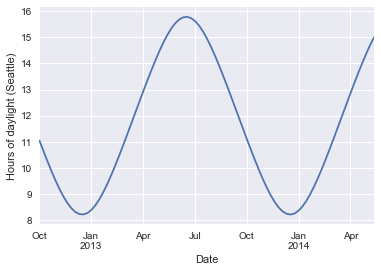

In [6]:
# Hours of daylight

from seattlecycling.tools import hours_of_daylight

weekly['daylight'] = list(map(hours_of_daylight, weekly.index))

weekly['daylight'].plot()
plt.ylabel('Hours of daylight (Seattle)');

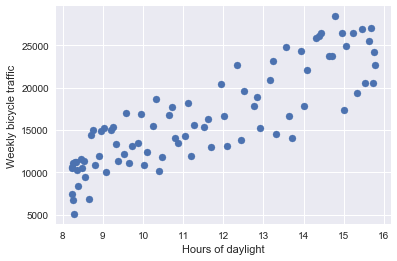

In [19]:
# Relationship between daylight and cycle traffic

plt.scatter(weekly.daylight, weekly.total)
plt.xlabel('Hours of daylight')
plt.ylabel('Weekly bicycle traffic');

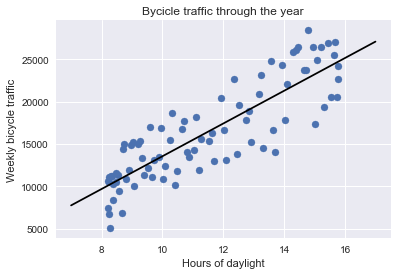

In [29]:
# Adding a linear trend

from sklearn.linear_model import LinearRegression

X = weekly[['daylight']]
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly.total - weekly.daylight_trend + np.mean(weekly.daylight_trend)

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])

plt.scatter(weekly.daylight, weekly.total)
plt.plot(xfit, yfit, '-k')
plt.title('Bycicle traffic through the year')
plt.xlabel('Hours of daylight')
plt.ylabel('Weekly bicycle traffic');

In [21]:
clf.coef_[0]

1931.201014112695

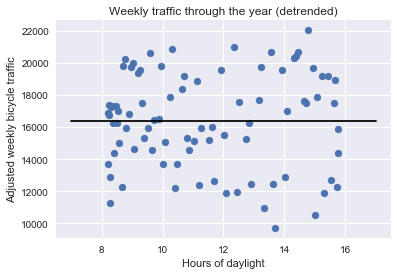

In [24]:
# Plot detrended data

trend = clf.predict(weekly[['daylight']].values)
plt.scatter(weekly.daylight, weekly.total - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title('Weekly traffic through the year (detrended)')
plt.xlabel('Hours of daylight')
plt.ylabel('Adjusted weekly bicycle traffic');

In the graph above, we have removed the number of riders per week that correlate with the number of hours of daylight, so that we can think of what is shown of the number of rides per week we'd expect to see if daylight was not an issue.

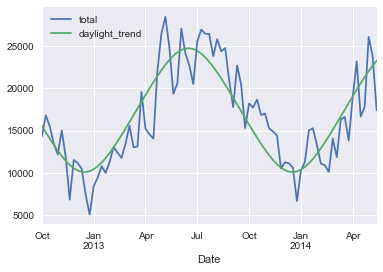

In [34]:
# Plot total riders and trend over time

weekly[['total', 'daylight_trend']].plot();

Root-mean-square about trend:  2942 riders


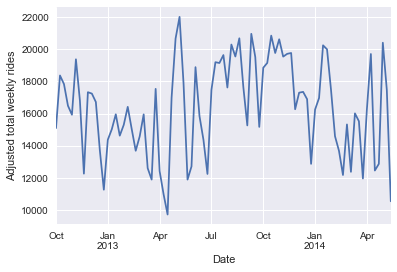

In [36]:
# Remove trend from total

rms = np.std(weekly['daylight_corrected_total'])
weekly['daylight_corrected_total'].plot()
plt.ylabel('Adjusted total weekly rides')
print('Root-mean-square about trend: {0: .0f} riders'.format(rms))